# Assignment 2 : semantic frame parsing using conditional random fields <br>
This notebook contains a limited implementation of the paper "Semantic Frame Parsing for Information Extraction : the CALOR corpus". Limited because we only train and test using 3 different frames. <br>

First we will define code for parsing all the corpus data, after parsing we are left with a set of sentences and 3 sets of labels.<br>
- semantic label : The semantic label B is given to the first frame element in a sentence, all other frame elements are labeled as I. And words that are not part of a frame are labeled as O. 
- frame label : The frame label shows to which of the 3 possible frames the word belongs. Or none if it doesn't belong to any.
- frame_element label: The label FE is given when a word is part of a frame, the label Target is given when the word is a lexical unit for the frame and all other samples are labeled as none.<br>

If a sentence is part of 2 frames, we will duplicate the sample for each of the possible labels. 

In [1]:
from itertools import chain
from pandas import DataFrame
import os
import csv
import pickle
import numpy as np
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import scipy
from sklearn.model_selection import train_test_split
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
dir = os.path.dirname('__file__')
Data_root = os.path.join(dir, 'calor_frames/')
Semantic_labels = ['O', 'B', 'I']
Frame_labels = ['Existence', 'Locating' , 'Departing' , 'none']
FE_labels = ['FE', 'TARGET', 'none']
lexical_units =  [] 

def split_label(label,lemma):
    l = label.split(":")
    if len(l) == 6:
        sem_label, fram_label, fe_label, target, _, _ = l
        if ( (fe_label == 'TARGET') and not(lemma in lexical_units) and (fram_label in Frame_labels) ):
            lexical_units.append(lemma)
        if not(fram_label in Frame_labels):
                sem_label, fram_label, fe_label  = Semantic_labels[0] ,Frame_labels[3], FE_labels[2]
    else:
        sem_label, fram_label, fe_label  = Semantic_labels[0] ,Frame_labels[3], FE_labels[2]
    return [sem_label, fram_label, fe_label]
def load_data(root = Data_root, load= False):
    Sentences = []
    Labels = []
    sentence = []
    sentence_labels =[]
    if load:
        with open ('sentences', 'rb') as fp:
            Sentences = pickle.load(fp)
        with open ('labels', 'rb') as fp:
            Labels = pickle.load(fp)
    else:
        for subdir, dirs, files in os.walk(Data_root):
            for file in files:
                if file[len(file)-3:] == 'tsv':
                    f = (os.path.join(subdir, file))
                    with open(f) as tsvfile:
                        tsvreader = csv.reader(tsvfile, delimiter="\t")
                        for line in tsvreader:
                            sentence_labels2 = []
                            two_frames = False
                            if (len(line) == 12):  # not part of a frame
                                name, global_idx, local_idx, word, lemma, pos_tag1, pos_tag2, dep1, dep_id, dep_name,_,_ = line
                                label1 = split_label('',lemma)
                                sentence.append([lemma,pos_tag2])
                                sentence_labels.append(label1)
                                sentence_labels2.append(label1)
                            if (len(line) == 13):  # part of frame
                                name, global_idx,local_idx, word, lemma, pos_tag1, pos_tag2, dep1, dep_id, dep_name,_,_, label = line
                                sentence.append([lemma,pos_tag2])
                                label1 = split_label(label,lemma)
                                sentence_labels.append(label1)
                                sentence_labels2.append(label1)
                            if (len(line) == 14):  # part of 2 frames
                                two_frames = True
                                name, global_idx,local_idx, word, lemma, pos_tag1, pos_tag2, dep1, dep_id, dep_name,_,_, label, label2 = line
                                sentence.append([lemma,pos_tag2])
                                label1, label2 = split_label(label,lemma), split_label(label2,lemma)
                                sentence_labels.append(label1)
                                sentence_labels2.append(label2)
                            if (len(line) == 0): # new sentence
                                Sentences.append(sentence)
                                Labels.append(sentence_labels)
                                if two_frames != False:
                                    Sentences.append(sentence)
                                    Labels.append(sentence_labels2)
                                    two_frames = False
                                sentence,sentence_labels = [],[]
    with open('sentences', 'wb') as fp:
        pickle.dump(Sentences, fp)
    with open('labels', 'wb') as fp:
        pickle.dump(Labels, fp)
    return Sentences, Labels

## split the corpus <br>
Below we will define functions to split the corpus into multiple corpuses as discussed in the paper. For each lexical unit a corpus is created of only sentences that contain that lexical unit. 

In [2]:
def create_corpussus(Sentences,Labels):
    sentences_per_corpus = [[] for _ in range(0,len(lexical_units))]
    labels_per_corpus = [[] for _ in range(0,len(lexical_units))]
    for s,l in zip(sentences, labels):
        in_frames = False
        for word_and_pos, word_label in zip (s,l):
            word = word_and_pos[0]
            sem_label, fram_label, fe_label = word_label
            if word in lexical_units:
                in_frames = word
        if in_frames != False:
            index = lexical_units.index(in_frames)
            sentences_per_corpus[index].append(s)
            labels_per_corpus[index].append(l)
    return labels_per_corpus, sentences_per_corpus

## Here we will define our preprocessing <br>
Feature extraction is done for every word and corresponding label, for every word we include the word and positional tag of itself and its neighboor in both directions. 

In [3]:
def preprocess_sentence(sent):
    result = []
    for i,data in enumerate(sent):
        word = data[0]
        postag = data[1]
        features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
        }
        if i > 0:
            word1 = sent[i-1][0]
            postag1 = sent[i-1][1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.istitle()': word1.istitle(),
                '-1:word.isupper()': word1.isupper(),
                '-1:postag': postag1,
                '-1:postag[:2]': postag1[:2],
            })
        else:
            features['BOS'] = True

        if i < len(sent)-1:
            word1 = sent[i+1][0]
            postag1 = sent[i+1][1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.istitle()': word1.istitle(),
                '+1:word.isupper()': word1.isupper(),
                '+1:postag': postag1,
                '+1:postag[:2]': postag1[:2],
            })
        else:
            features['EOS'] = True
        result.append(features)
    return result       
def preprocess_labels(nested_labels):
    Y_semantic = []
    Y_frame = []
    Y_fe = []
    y_Combined = []
    for Labels in nested_labels:
        y_semantic = []
        y_frame = []
        y_fe = []
        y_combined = []
        for semantic_label, frame_label, fe_label in Labels:
            y_semantic.append(semantic_label)
            y_frame.append(frame_label)#Frame_labels.index(frame_label))
            y_fe.append(fe_label)
            y_combined.append(semantic_label+':'+frame_label+':'+fe_label)
        Y_semantic.append(y_semantic)
        Y_frame.append(y_frame)
        Y_fe.append(y_fe)
        y_Combined.append(y_combined)
    return Y_semantic , Y_frame, Y_fe, y_Combined
def preprocess_data(sent,Labels):
    X_data= [] 
    for s in sent:
        X_data.append(preprocess_sentence(s))
    y_semantic , Y_frame, y_fe, y_combined =preprocess_labels(Labels)
    return X_data, y_semantic , Y_frame, y_fe, y_combined

## splitting corpusses <br>
The code below is used to split the corpus into multiple corpusses, one per lexical unit.

In [4]:
sentences, labels = load_data()
#split corpus in one corpus per possible frames, containing only sentences that contain a lexical unit for that frame
labels_per_corpus, sentences_per_corpus= create_corpussus(sentences,labels)
for i, corpus in enumerate(sentences_per_corpus):
    print( "lenth of corpus "+ str(i)+ " for " + lexical_units[i] + " is " + str(len(corpus)))

lenth of corpus 0 for trouver is 1168
lenth of corpus 1 for exister is 250
lenth of corpus 2 for retrouver is 589
lenth of corpus 3 for localisation is 63
lenth of corpus 4 for existence is 152
lenth of corpus 5 for quitter is 194
lenth of corpus 6 for départ is 137


## training our models <br>
For each of these corpusses we will train a conditional random field, the label that will be used is all of the 3 other labels appended to eachother. <br>
For semantic and frame_element labels there are 3 different possibilities and for frame label there are for. This makes the total number of possible labels 3X3X4 = 36.

In [5]:
#preprocess each corpus
x_data , y_semantic , Y_frame , y_fe, y_combined = [], [], [], [], []
for data, labels in zip(sentences_per_corpus,labels_per_corpus ):
    X_data_ci, y_semantic_ci , Y_frame_ci, y_fe_ci, y_combined_ci = preprocess_data(data,labels)
    x_data.append(X_data_ci)
    y_semantic.append(y_semantic_ci)
    Y_frame.append(Y_frame_ci)
    y_fe.append(y_fe_ci)
    y_combined.append(y_combined_ci)

In [6]:
CRF_i = []
final_test_x = [] 
final_test_y = []
combined_y  = []
for x,y in zip(x_data, y_combined):
    X_train_c1, X_test_c1, y_train_c1, y_test_c1 = train_test_split(x, y, test_size=0.2)
    crf_c1 = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.3,
    c2=0.2,
    max_iterations=100,
    all_possible_transitions=True
    ).fit(X_train_c1, y_train_c1)
    CRF_i.append(crf_c1)
    final_test_x.extend(X_test_c1)
    final_test_y.extend(y_test_c1)

## filter predictions
In the paper a filter is used to only keep valid predictions, here we will do the same. The code below filters out all predictions that don't satisfy the following 2 constrains: <br>
- The first frame element is labeled as B
- The sentence contains a lexical unit

In [7]:
def coherence_filter(sentence, sentence_labels):
    contains_target = False
    starts_with_b = False
    first = True
    for word ,label in zip(sentence, sentence_labels):
        word = word['word.lower()']
        semantic, frame, fe = label.split(':')
        if semantic != 'O':
            if semantic == 'B' and first:
                starts_with_b = True
            first = False
        if fe == 'TARGET':
            contains_target = True
    return (contains_target and starts_with_b )

In [8]:
predictions_i = []
labels = list(CRF_i[0].classes_)
for i in range(0,len(CRF_i)):
    pred = CRF_i[i].predict(final_test_x)
    predictions_i.append(pred)

In [9]:
filtered_indexes = np.zeros([len(predictions_i), len(final_test_x)])
for i, pred in enumerate(predictions_i):
    j = 0
    for sentence,prediction in zip (final_test_x, pred):
        keep = coherence_filter(sentence,prediction)
        if keep:
            filtered_indexes[i,j] = 1
        j+=1

In [10]:
samples_global =[]
predictions_global =[]
labels_global = []
for i in range(0, filtered_indexes.shape[1] ):
    for j, val in enumerate(filtered_indexes[:,i]):
        if int(val) == 1:
            x_sample = final_test_x[i]
            y_sample = final_test_y[i]
            y_pred = predictions_i[j][i]
            samples_global.append(x_sample)
            labels_global.append(y_sample)
            predictions_global.append(y_pred)

## Evaluating results <br>
In the code below we will evaluate the predictions that were kept after filtering out. <br>
For statistical analysis over the whole test set, I will present the F1 score, Q3 score, MCC score and multiple confusion matrices for each of the 3 labels. 

In [11]:
def get_confusion_matrices(preds,labels):
    matrix_frames = np.zeros([len(Frame_labels) , len(Frame_labels)])
    matrix_fe = np.zeros([len(FE_labels) , len(FE_labels)])
    matrix_sem = np.zeros([len(Semantic_labels) , len(Semantic_labels)])
    for pred, truth in zip(preds,labels):
        for predicted_label, true_label in zip(pred,truth):
            semantic_pred, frame_pred, fe_pred = predicted_label.split(':')
            semantic_true, frame_true, fe_true = true_label.split(':')
            semantic_pred, frame_pred, fe_pred = Semantic_labels.index(semantic_pred) , Frame_labels.index(frame_pred), FE_labels.index(fe_pred)
            semantic_true, frame_true, fe_true = Semantic_labels.index(semantic_true) , Frame_labels.index(frame_true), FE_labels.index(fe_true)
            matrix_frames[frame_pred,frame_true] +=1
            matrix_fe[fe_pred,fe_true] +=1
            matrix_sem[semantic_pred,semantic_true] +=1
    return matrix_frames, matrix_fe, matrix_sem

In [12]:
#Prints out the confusion matrix aswell as precision recall and F-score for each class
def printResult(matrix,labels):
    mcc =printStats(matrix,labels)
    plot_matrix(matrix,labels)
    return matrix ,mcc

def plot_matrix(conf_mat,labels):
    conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    f_cm = pd.DataFrame(conf_mat_normalized, labels,
                  labels)
    sn.heatmap(f_cm)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def printStats(matrix,labels):
    i = 0
    MCC = MCCscore(matrix)
    Q1 = Q1Score(matrix)
    F1 = F1_score (matrix)
    for mcc , q1, f1 in zip ( MCC , Q1, F1):
        l = labels[i]
        i+=1
        print("The MCC score for " + l + " equal " + "{0:0.2f}".format(mcc))
        print("The Q1 score for " + l + " equal " + "{0:0.2f}".format(q1))
        print("The F1 score for " + l + " equal " + "{0:0.2f}".format(f1))
    print("mean MCC score = " + "{0:0.2f}".format(np.mean(MCC)))
    print("mean Q1 score = " + "{0:0.2f}".format(np.mean(Q1)))
    print("mean F1 score = " + "{0:0.2f}".format(np.mean(F1)))
    return  np.mean(MCC)

def F1_score (matrix):
    res = np.zeros(matrix.shape[0])
    for i in range (0,len(res)):
        TP = matrix[i][i]
        TN = np.sum ( np.delete (np.delete(matrix, i, 0), i, 1))
        FP = np.sum(matrix[:,i])-TP
        FN = np.sum(matrix[i,:]) - TP
        TP, FP, FN = np.max([TP,1]),np.max([FP,1]),np.max([FN,1])
        recall = TP/ (TP+FN)
        precision = TP/ (TP+FP)
        f1 = 2* (precision*recall)/ (precision+recall)
        res[i] += f1
    return res

def Q1Score (matrix):
    res = np.zeros(matrix.shape[0])
    for i in range (0,len(res)):
        total = np.sum(matrix[i])
        correct = matrix[i][i]
        total = np.max([total,1])
        res[i] += float(correct)/float(total)
    return res

def MCCscore(matrix):
    res = np.zeros(matrix.shape[0])
    for i in range (0,len(res)):
        TP = matrix[i][i]
        TN = np.sum ( np.delete (np.delete(matrix, i, 0), i, 1))
        FP = np.sum(matrix[:,i])-TP
        FN = np.sum(matrix[i,:]) - TP
        TP, FP, FN = np.max([TP,1]),np.max([FP,1]),np.max([FN,1])
        mcc = (TP*TN - FP * FN) / np.sqrt( (TP+FP) * (TP+FN) * (TN+FP) * (TN+FN) )
        res[i] += mcc
    return res

## evaluating statistical metrices over test set

In [13]:
matrix_frames, matrix_fe, matrix_sem = get_confusion_matrices(predictions_global,labels_global)

--------------   results for frame classification --------------------
The MCC score for Existence equal 0.44
The Q1 score for Existence equal 0.65
The F1 score for Existence equal 0.44
The MCC score for Locating equal 0.56
The Q1 score for Locating equal 0.81
The F1 score for Locating equal 0.63
The MCC score for Departing equal 0.74
The Q1 score for Departing equal 0.85
The F1 score for Departing equal 0.73
The MCC score for none equal 0.53
The Q1 score for none equal 0.80
The F1 score for none equal 0.86
mean MCC score = 0.57
mean Q1 score = 0.78
mean F1 score = 0.67


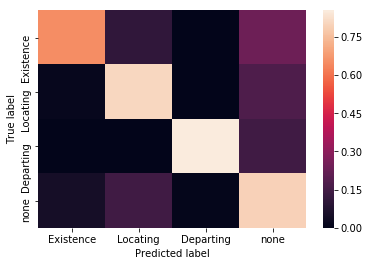

In [14]:
print("--------------   results for frame classification --------------------")
_=printResult(matrix_frames, Frame_labels)

--------------   results for frame element classification --------------------
The MCC score for FE equal 0.49
The Q1 score for FE equal 0.79
The F1 score for FE equal 0.58
The MCC score for TARGET equal 0.96
The Q1 score for TARGET equal 0.96
The F1 score for TARGET equal 0.97
The MCC score for none equal 0.53
The Q1 score for none equal 0.80
The F1 score for none equal 0.86
mean MCC score = 0.66
mean Q1 score = 0.85
mean F1 score = 0.80


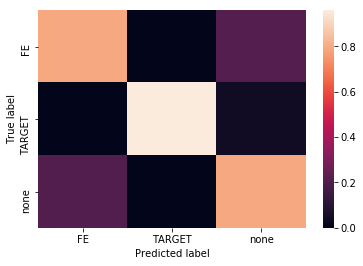

In [15]:
print("--------------   results for frame element classification --------------------")
_=printResult(matrix_fe,FE_labels)

--------------   results for semantic label classification ------------------
The MCC score for O equal 0.53
The Q1 score for O equal 0.80
The F1 score for O equal 0.86
The MCC score for B equal 0.74
The Q1 score for B equal 0.87
The F1 score for B equal 0.76
The MCC score for I equal 0.46
The Q1 score for I equal 0.73
The F1 score for I equal 0.52
mean MCC score = 0.58
mean Q1 score = 0.80
mean F1 score = 0.72


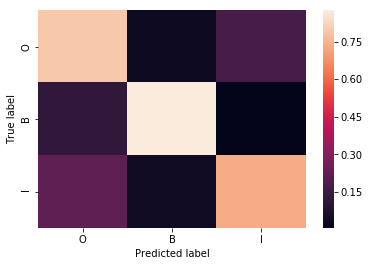

In [16]:
print("--------------   results for semantic label classification ------------------")
_= printResult(matrix_sem,Semantic_labels)

In [17]:
from sklearn.metrics import classification_report 
flatten = lambda l: [item for sublist in l for item in sublist]
score_1 =  metrics.flat_f1_score(labels_global, predictions_global,
                      average='weighted', labels=labels)
print(classification_report(flatten(labels_global), flatten(predictions_global)))
print("F1-score for set of 36 classifications : " + "%.2f" % score_1)

                    precision    recall  f1-score   support

    B:Departing:FE       0.83      0.63      0.72       106
B:Departing:TARGET       0.93      0.97      0.95        40
    B:Existence:FE       0.58      0.24      0.34       171
B:Existence:TARGET       0.94      0.94      0.94       104
     B:Locating:FE       0.82      0.55      0.66       842
 B:Locating:TARGET       0.97      0.98      0.97       368
    I:Departing:FE       0.79      0.54      0.64       192
    I:Existence:FE       0.54      0.25      0.34       700
     I:Locating:FE       0.73      0.41      0.53      2725
       O:none:none       0.80      0.94      0.86     10739

       avg / total       0.78      0.79      0.77     15987

F1-score for set of 36 classifications : 0.77


## Discussion <br>
We decided to display the results of each classification seperately to give a clearer overview of which parts are most difficult. <br>
Frame classification : We see that "existance" has the lowest precision, this is most likely because this was one of the least frequent occuring frames in the corpus. <br>

Frame element classification: We see that no mistakes were made in correctly identifying the lexical unit, however sometimes it mislabeles frame elements. <br>

Semantic classification: We see that the model is quite certain about when a word should be labeled as 'B', however it does make some mistakes in labeling 'I' and 'O'(whether a word is inside the frame).

## Evaluating single samples

In [18]:
pred1 = predictions_global[54]
true1 = labels_global[54]
sample = samples_global

In [19]:
def print_sample(index):
    pred = predictions_global[index]
    true = labels_global[index]
    sample = samples_global[index]
    sample = [w['word.lower()'] for w in sample]
    sample_string = ' '.join(sample)
    correct,incorrect = 0,0
    print(sample_string + '\n')
    for p,t,s in zip(true,pred,sample):
        print("target : \t " + t + " \t prediction: " + p +' \t word :' + s+ '\n')
        if t==p:
            correct+=1
        else:
            incorrect +=1
    accuracy = float(float(correct)/float((correct+incorrect)))
    print (str(correct) +"/" +str(correct+incorrect) + " predictions were correct")

In [20]:
print_sample(440)

l' archéologue christian goudineau s' interroger sur le existence de un délai entre le fondation et le installation des premier colon mais conclure que rien ne permettre de#l' affirmer ou de#l' infirmer en expliquer que le couche stratigraphiques de référence , pour le période 50 av.

target : 	 O:none:none 	 prediction: B:Existence:FE 	 word :l'

target : 	 O:none:none 	 prediction: I:Existence:FE 	 word :archéologue

target : 	 O:none:none 	 prediction: I:Existence:FE 	 word :christian

target : 	 O:none:none 	 prediction: I:Existence:FE 	 word :goudineau

target : 	 O:none:none 	 prediction: I:Existence:FE 	 word :s'

target : 	 O:none:none 	 prediction: I:Existence:FE 	 word :interroger

target : 	 O:none:none 	 prediction: O:none:none 	 word :sur

target : 	 O:none:none 	 prediction: O:none:none 	 word :le

target : 	 B:Existence:TARGET 	 prediction: B:Existence:TARGET 	 word :existence

target : 	 O:none:none 	 prediction: B:Existence:FE 	 word :de

target : 	 O:none:none 	 predi

In [21]:
print_sample(9)

on trouver de le terre partout , dans son poche , dans son mouchoir , dans son habit , dans ce#qu' on manger .

target : 	 B:Locating:FE 	 prediction: B:Locating:FE 	 word :on

target : 	 B:Locating:TARGET 	 prediction: B:Locating:TARGET 	 word :trouver

target : 	 B:Locating:FE 	 prediction: O:none:none 	 word :de

target : 	 I:Locating:FE 	 prediction: B:Locating:FE 	 word :le

target : 	 I:Locating:FE 	 prediction: I:Locating:FE 	 word :terre

target : 	 I:Locating:FE 	 prediction: B:Locating:FE 	 word :partout

target : 	 I:Locating:FE 	 prediction: I:Locating:FE 	 word :,

target : 	 I:Locating:FE 	 prediction: I:Locating:FE 	 word :dans

target : 	 I:Locating:FE 	 prediction: I:Locating:FE 	 word :son

target : 	 I:Locating:FE 	 prediction: I:Locating:FE 	 word :poche

target : 	 O:none:none 	 prediction: I:Locating:FE 	 word :,

target : 	 O:none:none 	 prediction: I:Locating:FE 	 word :dans

target : 	 O:none:none 	 prediction: I:Locating:FE 	 word :son

target : 	 O:none:none 

In [33]:
print_sample(488)

on quitter bavay par le route de maubeuge d95 puis n49 que l'on abandonner à son premier virage pour gagner feignies où elle porter le nom de rue de le chaussée brunehault .

target : 	 B:Departing:FE 	 prediction: B:Departing:FE 	 word :on

target : 	 B:Departing:TARGET 	 prediction: B:Departing:TARGET 	 word :quitter

target : 	 B:Departing:FE 	 prediction: B:Departing:FE 	 word :bavay

target : 	 O:none:none 	 prediction: B:Departing:FE 	 word :par

target : 	 O:none:none 	 prediction: I:Departing:FE 	 word :le

target : 	 O:none:none 	 prediction: I:Departing:FE 	 word :route

target : 	 O:none:none 	 prediction: I:Departing:FE 	 word :de

target : 	 O:none:none 	 prediction: I:Departing:FE 	 word :maubeuge

target : 	 O:none:none 	 prediction: I:Departing:FE 	 word :d95

target : 	 O:none:none 	 prediction: I:Departing:FE 	 word :puis

target : 	 O:none:none 	 prediction: I:Departing:FE 	 word :n49

target : 	 O:none:none 	 prediction: O:none:none 	 word :que

target : 	 O:none:no

## Discussion <br>
We evaluated 3 samples all displaying a different frame, on all these samples the model performed decent. It always managed to find the correct target, but sometimes it recognises frame elements where there are none.